**Agenda**

Here is the agenda for today:

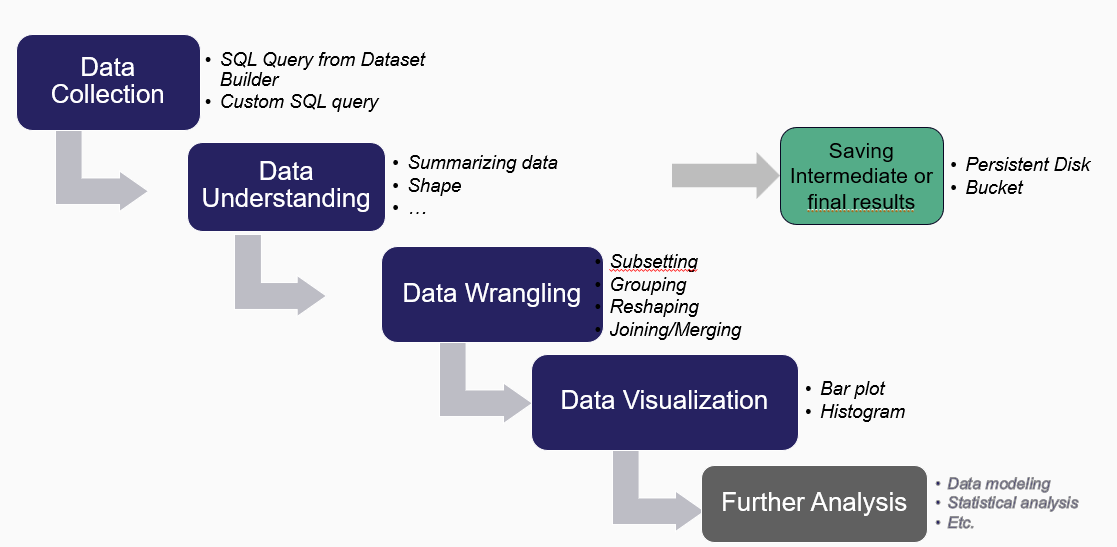

We will go through a standard data analysis process. 
 - explain a bit of each step
 - we will not fo the further analysis
 - I will show you how to save internmediate or final results into your peristent disk or bucket. Bucket recommended
 - all within RStudio, Jupyter notebook or SAS studio
 


-------------


**LIVE DEMO starts**

Here are your environment options. 
 - After you start the environment of your choosing, you can create an analysis notebook or markdown document.
 - I have created example Jupyter notebooks in Python and R to quickly show you. Show a bit in Py and R.
 - When you open your notebook, you need to click on edit so that you can run and save your analysis - the playground mode does not save anything
     - this is an example of code imported from the DB. The first thing you need to do is to run the code to get an R or Python dataframe. The datframe you get is what you will use for further wrangling or analysis.
       - to run do this:
       -exlain sql BRIEFLY

**Now let's open RStudio to start our data analysis**

-------

# Data Collection

AoU data is stored in Google BigQuery, wich is a data warehouse. You need to use SQL (Structured Query Language) to extract data from Big Query.
You have a few options to AoU collect data with SQL.

## Query from the Dataset Builder

We have quite a few ressources on how to do this, so please refer to them. If you don't know where they are, we can point you to them. 

After you have created your cohort and your dataset, you will be able to import your query and the resulting DataFrame in a Python or R Jupyter Notebook. and it will look like the below.

The read part is the SQL query and it is wrapped by R code, which is able to turn it into a table and load it into a dataframe.

In [ ]:
library(tidyverse)
library(bigrquery)

# This query represents dataset "Metabolic disease" for domain "condition" and was generated for Synthetic Dataset v4
dataset_40426116_condition_sql <- paste("
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code 
    FROM
        ( SELECT
            * 
        FROM
            `condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `cb_criteria` c 
                    JOIN
                        (
                            SELECT
                                CAST(cr.id as string) AS id       
                            FROM
                                `cb_criteria` cr       
                            WHERE
                                concept_id IN (
                                    436670
                                )       
                                AND full_text LIKE '%_rank1]%'      
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )
            ) c_occurrence 
        LEFT JOIN
            `concept` c_standard_concept 
                ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
        LEFT JOIN
            `concept` c_type 
                ON c_occurrence.condition_type_concept_id = c_type.concept_id 
        LEFT JOIN
            `visit_occurrence` v 
                ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
        LEFT JOIN
            `concept` visit 
                ON v.visit_concept_id = visit.concept_id 
        LEFT JOIN
            `concept` c_source_concept 
                ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
condition_40426116_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "condition_40426116",
  "condition_40426116_*.csv")
message(str_glue('The data will be written to {condition_40426116_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_40426116_condition_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  condition_40426116_path,
  destination_format = "CSV")


# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {condition_40426116_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(standard_concept_name = col_character(), standard_concept_code = col_character(), standard_vocabulary = col_character(), condition_type_concept_name = col_character(), stop_reason = col_character(), visit_occurrence_concept_name = col_character(), condition_source_value = col_character(), source_concept_name = col_character(), source_concept_code = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
dataset_40426116_condition_df <- read_bq_export_from_workspace_bucket(condition_40426116_path)

dim(dataset_40426116_condition_df)

head(dataset_40426116_condition_df, 5)

`dataset_18023747_condition_df` is your dataframe

A DataFrame is a data structure that organizes data into a 2-dimensional table of rows and columns, much like a spreadsheet. You dataset is stored into a dataframe and this is what you will wrangle.

**packages**

The first thing you do when opening any notebook or RStudio env is to import the packages you need. Today we will use 3 packages:

 - tidyverse #for data wrangling
 - bigrquery # to read data from Google Bigquery into R
 
We already saw these
 - gplot2 # for data visualization

Tidyverse and ggplot2 are industry standard to do what they do. I recommand sticking to them for data wrangling and visualizations in R. Of course, you can install any other libraries you need for further analysis.

4 Cheat sheets here. will be using the middle 2 mostly. scuccint summary of data wrangling methods with dlpyr and tidyr - 
**Credit/References: R Cheatsheets:** 

- `Base R Cheat Sheet`
- `Data transformation with dplyr::CHEAT SHEET`
- `Data tidying with tidyr : : CHEAT SHEET - GitHub`
- `introduction to ggplot2 Cheat Sheet - Data Camp`

https://iqss.github.io/dss-workshops/R/Rintro/base-r-cheat-sheet.pdf

https://raw.githubusercontent.com/rstudio/cheatsheets/main/data-transformation.pdf

https://raw.githubusercontent.com/rstudio/cheatsheets/main/tidyr.pdf

https://www.datacamp.com/cheat-sheet/ggplot2-cheat-sheet

----------

## Custom SQL Query

Your secod option is to build your own SQL query. As some of you know, sometimes you may need to do that. For example if you want to see the visit timeline of a patient, you will need to write a SQL query for that. If you need certain custom calculations and so on.

*Not teaching SQL today but we will need the datframes for demosntrating wrangling*

In [ ]:
# This is a helper function to help you to easily query and load data from the CDR
download_data <- function(query) {
    tb <- bq_project_query(Sys.getenv('GOOGLE_PROJECT'), query = query, page_size = 25000
                          , default_dataset = Sys.getenv('WORKSPACE_CDR'))
    bq_table_download(tb)
}

### Demo data

In [ ]:
person_df <- download_data(" SELECT DISTINCT 
                    person_id, 
                    birth_datetime,
                    sex_at_birth_source_value AS sex_at_birth, 
                    race_source_value AS race, 
                    gender_source_value AS gender, 
                    ethnicity_source_value AS ethnicity,
                    state_of_residence_source_value AS state,
        
                    FROM `person` ")

head(person_df)

### Heart Rate Summary

In [ ]:
query <- str_glue("
SELECT
    DISTINCT person_id
    , date
    , zone_name
    , min_heart_rate
    , max_heart_rate
    , minute_in_zone
    , calorie_count
FROM `heart_rate_summary`
WHERE date > '2019-10-31'
LIMIT 10000
")
fitbit_hr_df <- download_data(query)
head(fitbit_hr_df)

### The Basics Survey

In [ ]:
query <- str_glue("
    SELECT DISTINCT person_id, question, answer
    FROM `ds_survey`  
    WHERE survey = 'The Basics'
     ")

# Using the download_data() function, query and load the data into a dataframe df
the_basics_df <- download_data(query)
head(the_basics_df)

### EHR Visit Data, including timeline

In [ ]:
visit_df <- download_data("
    SELECT 
        DISTINCT person_id
        , visit_concept_id
        , concept_name as visit_concept_name
        , visit_start_datetime
        , visit_end_datetime
        , visit_occurrence_id
        
    FROM `visit_occurrence`
    JOIN `concept` on concept_id = visit_concept_id
    limit 20000")
head(visit_df)

###  EHR Condition Data: Malignant neoplastic disease"

In [ ]:
# Write SQL query and wrap it with R code
cancer_df <- download_data("
    SELECT 
        DISTINCT person_id
        , condition_concept_id
        , standard_concept_name
        , condition_start_datetime
        , condition_end_datetime
        , visit_occurrence_id
        
    FROM `ds_condition_occurrence` co 
    JOIN `concept_ancestor` c_a on (condition_concept_id=descendant_concept_id)
    WHERE ancestor_concept_id=  443392 ---Malignant neoplastic disease")
head(cancer_df)

### Physical Measurement Data

In [ ]:
ppi_pm_df <- download_data("
    SELECT 
        DISTINCT 
            person_id, 
            measurement_source_value as physical_measurement,
            measurement_datetime, 
            value_as_number, 
            unit_source_value,
            visit_occurrence_id
    FROM `measurement` AS m
    JOIN `measurement_ext` AS mm on m.measurement_id = mm.measurement_id
    WHERE 
        mm.src_id = 'PPI/PM'
        AND m.visit_occurrence_id IS NOT NULL
        AND value_as_number IS NOT NULL
        AND lower(measurement_source_value) IN ('blood-pressure-systolic-mean', 'blood-pressure-diastolic-mean'
                                                , 'heart-rate-mean', 'hip-circumference-mean'
                                                , 'waist-circumference-mean'
                                                )
   ")
head(ppi_pm_df)

# Data Understanding and summarizing

`head()/tail()`, `n_distinct()`, `unique()`, `summarise()`, `glimpse()`

`df` or `View(df)`: to view the entire dataframe. Note that you won't be able to see every row - **not recommended

In [ ]:
# Simply run: df or View(df)
dataset_18023747_condition_df

`head(df, n)`; `tail(df, n)`: See the first or last n rows, including the column names, of a dataframe. The default n = 5

In [ ]:
head(dataset_18023747_condition_df)

In [ ]:
tail(dataset_18023747_condition_df, 2)

`glimpse(df)`: Compactly display the structure of your dataframe (number of rows and columns, column names, column data types, some column values)

Use `dim(df)` to simply see the number of rows and columns of your dataframe

In [ ]:
#glimpse(df) OR str(df)
glimpse(cancer_df)

In [ ]:
dim(cancer_df)

`unique(df$column_name)`: see the unique values in a column 

In [ ]:
unique(cancer_df$standard_concept_name)

`n_distinct(df$column_name)`: count the unique values in a column 

In [ ]:
n_distinct(visit_df$person_id)

`summarize()`: apply a summary function to a column or an entire dataframe

In [ ]:
summarize(the_basics_df, n_questions = n_distinct(question))

In [ ]:
summarize_all(the_basics_df, n_distinct)

# Data wrangling

## Subsetting data: Filtering rows and selecting columns

`filter(data, condition)` to Extract **rows** where column meet logical criteria.

In [ ]:
head(visit_df,2)

People with data in visit on or after 2003

In [ ]:
filter(visit_df, visit_start_datetime >= '2003-01-01')

In [ ]:
visits_2003_above_20212442 <- filter(visit_df, (visit_start_datetime >= '2003-01-01' & person_id == 20212442))

head(visits_2003_above_20212442,2)

In [ ]:
filter(visit_df, (visit_start_datetime >= '2003-01-01' 
                  & visit_concept_name == 'Outpatient Visit'))

In [ ]:
#you can do this in Base R as wll (no package needed)
marital_status_df = survey_df[survey_df$question == 'Marital Status: Current Marital Status',]
head(marital_status_df)

`select(data, columns)` to Extract columns

In [ ]:
head(fitbit_hr_df,1)

In [ ]:
ft_calories <- select(fitbit_hr_df, person_id)
head(ft_calories,2)

In [ ]:
ft_calories <- select(fitbit_hr_df, person_id, date)
or ft_calories <- select(fitbit_hr_df, c(person_id, date))

In [ ]:
fitbit_calories_df <- select(fitbit_hr_df, c('person_id','date','calorie_count'))
head(fitbit_calories_df)

In [ ]:
fitbit_no_calories_df <- select(fitbit_hr_df, -c('calorie_count'))
head(fitbit_no_calories_df)

## Grouping data: `group_by()` and `summarize()`

### Survey data 

`%>%` OR `|>` are R pipes. They are a way to chain multiple operations together in a concise and expressive way

In [ ]:
unique(select(the_basics_df, question, question_concept_id))

**Count the number of unique participants per question and answer in the basics** survey
 - select employment and insurance questions

In [ ]:
survey_count <- the_basics_df %>% filter(question_concept_id %in% c(1585386, 1585952)) %>%
                  select(-question_concept_id) %>%
                    group_by(question, answer) %>%
                    summarize(n_pids = n_distinct(person_id))

survey_count

In [ ]:
survey_count <- the_basics_df %>% group_by(question, answer) 
%>% summarize('n_pids' = n_distinct(person_id))
survey_count

## without pipes, the code would look like this:
# survey_count <- group_by(the_basics_df, question, answer)
# survey_count <- summarize(survey_count, 'n_pids' = n_distinct(person_id))

### Fitbit Data

In [ ]:
head(fitbit_hr_df)

In [ ]:
fitbit_count <- fitbit_hr_df %>% group_by(zone_name) %>% 
                summarize('avg_min_heart_rate' = mean(min_heart_rate)
                          , 'avg_max_heart_rate' = mean(max_heart_rate)
                          , 'avg_calorie_count' = mean(calorie_count)
                         )
fitbit_count


## Reshaping data: `pivot_wider()`

### Survey data

In [ ]:
head(the_basics_df)

In [ ]:
n_distinct(the_basics_df$person_id); dim(the_basics_df)

In [ ]:
survey_wider_df <- pivot_wider(the_basics_df, names_from = "question", values_from = "answer")
survey_wider_df

### Physical Measurements

In [ ]:
head(ppi_pm_df,2)

In [ ]:
ppi_pm_wider <- ppi_pm_df |>
            unite(col='physical_measurement', c("physical_measurement", "unit_source_value"), sep = ' in ') |>
            select(-c('measurement_datetime', 'visit_occurrence_id')) |>
            group_by(person_id, physical_measurement, value_as_number) |>
            summarise_all(funs(mean))  %>%
            pivot_wider(names_from = "physical_measurement", values_from = "value_as_number")
View(ppi_pm_wider)

In [ ]:
n_distinct(ppi_pm_wider2$person_id); dim(ppi_pm_wider2)

## Join/Merge Data

Ref: `Data transformation with dplyr : : CHEAT SHEET` -- > `Combine Tables`

### `inner_join()`: Retains only matching rows in both dataframes

In [ ]:
head(cancer_df,2)

In [ ]:
head(visit_df,2)

In [ ]:
cancer_visit <- inner_join(cancer_df, visit_df)
head(cancer_visit)

### `full_join()`: Join data. Retain all values, all rows from both datafframes

In [ ]:
head(survey_wider_df,2)

In [ ]:
head(ppi_pm_wider2,2)

In [ ]:
visit_and_survey_wide_df <- full_join(ppi_pm_wider2, survey_wider_df)
head(visit_and_survey_wide_df)

### `right_join()`: Returns all records from the right table (tdf2), and the matching records from the left table (df1)

In [ ]:
right_join(ppi_pm_wider2, the_basics_wider)

### `left_join()`: Returns all records from the left table (df1), and the matching records from the right table (df2)

## Visualizing Your Data

`ggplot(data, aes(x = x_column, y = y_column)) + geom_xxx()`: visualize data using plots

In [ ]:
ggplot(data = ppi_pm_df, mapping = aes(y = value_as_number)) + geom_histogram()

In [ ]:
# This snippet assumes that you run setup first

# This code saves your dataframe into a csv file in a "data" folder in Google Bucket

# Replace df with THE NAME OF YOUR DATAFRAME
my_dataframe <- df

# Replace 'test.csv' with THE NAME of the file you're going to store in the bucket (don't delete the quotation marks)
destination_filename <- 'test.csv'

########################################################################
##
################# DON'T CHANGE FROM HERE ###############################
##
########################################################################

# store the dataframe in current workspace
write_excel_csv(my_dataframe, destination_filename)

# Get the bucket name
my_bucket <- Sys.getenv('WORKSPACE_BUCKET')

# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./", destination_filename, " ", my_bucket, "/data/"), intern=T)

# Check if file is in the bucket
system(paste0("gsutil ls ", my_bucket, "/data/*.csv"), intern=T)


In [ ]:
# This snippet assumes that you run setup first

# This code copies a file from your Google Bucket into a dataframe

# replace 'test.csv' with the name of the file in your google bucket (don't delete the quotation marks)
name_of_file_in_bucket <- 'test.csv'

########################################################################
##
################# DON'T CHANGE FROM HERE ###############################
##
########################################################################

# Get the bucket name
my_bucket <- Sys.getenv('WORKSPACE_BUCKET')

# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ", my_bucket, "/data/", name_of_file_in_bucket, " ."), intern=T)

# Load the file into a dataframe
my_dataframe  <- read_csv(name_of_file_in_bucket)
head(my_dataframe)


In [ ]:
options(repr.plot.width = 20, repr.plot.height = 6) 
ggplot(data = ppi_pm_df, aes(x = physical_measurement)) + geom_bar(fill = 'blue') + 
theme(axis.text.x = element_text(size = 16#, angle = 45
                                ))